# Brain Networks Analysis using Graph Mining Techniques

Authors:
- Filippo Casagrande
- Jorge Morgado
- Hamed Aezami

First install the necessary packages

In [ ]:
%pip install networkx scikit-learn matplotlib numpy

⚠️ Before running this notebook first ensure you have the unzipped `brain_networks` dataset folder in the same directory of this notebook like this:

```text
.
├── brain_networks_analysis.ipynb
└── brain_networks
    ├── movie
    │   ├── 1_network_7networks.txt
    .   .   ...
    |   └── 248_network_7networks.txt
    └── story
        ├── 1_network_7networks.txt
        .   ...
        └── 248_network_7networks.txt
```

In [2]:
# Check if dataset is available and all files are present

from pathlib import Path

paths = [
    "brain_networks",
    "brain_networks/movie",
    "brain_networks/story",
]
paths.extend([f"brain_networks/movie/{i}_network_7networks.txt" for i in range(1, 249)])
paths.extend([f"brain_networks/story/{i}_network_7networks.txt" for i in range(1, 249)])

for path in paths:
    if not Path(path).exists():
        raise Exception(f"Dataset file (or folder) `{path}` not found")

print("All clear to go!")

All clear to go!


## Importing packages

We will use mainly:
- `networkx` for graph manipulation
- `sklearn` for classification metrics estimation
- `matplotlib` for plotting the results

In [3]:
import networkx as nx
import numpy as np

from pathlib import Path
from itertools import combinations

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# For reproducibility
SEED = 42

"""List of the 8 temporal graphs for a single subject."""
SubjectGraphData = list[nx.Graph]

## Loading the data

We define utility functions that will help us to load and parse the graphs

In [4]:
def load_graph_from_txt(file_path: str) -> SubjectGraphData:
    """
    Loads the 8 temporal graphs from a single experiment

    Parameters
    ----------
    file_path : str
        Path to the .txt file containing the 8 temporal graphs

    Returns
    -------
    SubjectGraphData
        List of the 8 temporal graphs for a single subject
    """

    graphs = [None for _ in range(8)]
    data = np.loadtxt(file_path, skiprows=1, dtype=float)
    data = data[:, -1]
    for i in range(8):
        start_idx = i * 10000
        end_idx = (i + 1) * 10000
        adj_matrix = data[start_idx:end_idx].reshape(100, 100)
        for j in range(100):
            adj_matrix[j, j] = 0
        graphs[i] = nx.from_numpy_array(adj_matrix)
    return graphs


def load_graphs(folder: str, with_label: str) -> list[SubjectGraphData]:
    """
    Loads all the 248 experiments from a folder

    Parameters
    ----------
    folder : str
        Path to the folder containing the experiments
    with_label : str
        Label to assign to the graphs

    Returns
    -------
    list[SubjectGraphData]
        List of the 248 experiments
    """
    graphs = [None] * 248
    for file in Path(folder).iterdir():
        print(f"Loading {file}", end="\r")
        idx = int(file.stem.split("_")[0]) - 1
        graphs[idx] = load_graph_from_txt(file)
        for G in graphs[idx]:
            G.graph["label"] = with_label
    assert all(graph is not None for graph in graphs)
    return graphs

Then, we load all the graphs from each experiment set and label them accordingly

In [5]:
m_graphs = load_graphs("./brain_networks/movie", with_label="movie")
s_graphs = load_graphs("./brain_networks/story", with_label="story")

graphs = m_graphs + s_graphs

## Splitting the data


First, let us define some utility functions

In [6]:
def split_by_label(
    graphs: list[SubjectGraphData],
) -> tuple[list[SubjectGraphData], list[SubjectGraphData]]:
    """
    Takes a list of subjects experiments and splits by labels (movie or story)

    Parameters
    ----------
    graphs : list[SubjectGraphData]
        List of experiments

    Returns
    -------
    tuple[list[SubjectGraphData], list[SubjectGraphData]]
        Tuple containing the subjects experiments split by label. First element
        is movie, second is story
    """
    movie, story = [], []
    for t_graphs in graphs:
        if t_graphs[0].graph["label"] == "movie":
            movie.append(t_graphs)
        else:
            story.append(t_graphs)
    return movie, story

The next function will be used to split the dataset (similar to the `train_test_split` function from sklearn)

In [7]:
def train_test_split(
    graphs: list[SubjectGraphData], train_size: float = 0.7, seed=None
) -> tuple[list[SubjectGraphData], list[str], list[SubjectGraphData], list[str]]:
    """
    Splits the subjects experiments randomly into train and test sets.

    Parameters
    ----------
    graphs : list[SubjectGraphData]
        List of experiments
    train_size : float
        Percentage of the experiments to use for training. Default is 0.7
    seed : int
        Seed for reproducibility

    Returns
    -------
    tuple[list[SubjectGraphData], list[str], list[SubjectGraphData], list[str]]
        Tuple containing the train and test sets and their respective labels.
        (train, train_labels, test, test_labels)
    """
    if seed is not None:
        np.random.seed(seed)

    np.random.shuffle(graphs)
    mov, sto = split_by_label(graphs)

    m_train_idx = int(len(mov) * train_size)
    s_train_idx = int(len(sto) * train_size)

    train = mov[:m_train_idx] + sto[:s_train_idx]
    test = mov[m_train_idx:] + sto[s_train_idx:]

    np.random.shuffle(train)
    np.random.shuffle(test)

    return (
        train,
        [t_graphs[0].graph["label"] for t_graphs in train],
        test,
        [t_graphs[0].graph["label"] for t_graphs in test],
    )

Next, we split the dataset in train and test subsets

In [8]:
X_train, y_train, X_test, y_test = train_test_split(graphs, seed=SEED)

## Classification according community detection

The classification algorithm we propose is based on community detection analysis.

Let $D$ be the set of experiments (8 graphs each), $L_i$ be the label of the $i$-th experiment (either movie or story), and $G_j^i$ be the graph of the $j$-th time stamp of the $i$-th experiment. For each graph on every time stamp on all the experiments we run a community detection algorithm, and then, for each experiment label, we build 8 graphs $A_1, ..., A_8$. Next we explain how each $A_k$ is built.

Each graph $A_k^m$ (and $A_k^s$ for the story experiments) contains 100 vertices (just as the dataset graphs). The value of each edge is defined as:

\begin{equation}
w(u,v) = \frac{\sum_{i=0}^{|D|} comm_k^i(u, v)}{|D|}
\end{equation}

where $|D|$ is the size of the dataset and $comm_k^i(u, v)$ is 1 if the vertices $u$ and $v$ belong to the same comunity in the $i$-th experiment at the $k$-th time stamp (0 if they were not in the same comunity).

Intuitivly, each $A_k$ edge contains the information of how likely are two nodes to be in the same comunity at the time $k$.

For classifying an unseen experiment, we run the same community detection algorithm for each time stamp graph $G_j$. Then, for each $G_j$ we sum the weights of the edges $(u, v)$ in each $A_j^m$ and $A_j^s$ if $u$ and $v$ were in the same community on $G_j$. Finally, we sum all the values of all the time stamps for each label, and depending on what was the label with the highest total value we classify the experiment accordingly.

The next function builds a graph $A_k^x$ given a set of graphs

In [9]:
def build_avg_community_graph(graphs: list[nx.Graph]) -> nx.Graph:
    """
    Build a graph where the weight of an edge is the average number of times
    (normalized) two nodes have been in the same community in the given graphs.

    Parameters
    ----------
    graphs : list[nx.Graph]
        List of graphs to analyze

    Returns
    -------
    nx.Graph
        Estimated graph
    """
    adj_matrix = np.zeros((100, 100), dtype=float)
    for i, G in enumerate(graphs):
        print(f"Analyzing graph {i + 1} of {len(graphs)}        ", end="\r")
        communities = nx.community.greedy_modularity_communities(G, weight="weight")
        for community in communities:
            for u, v in combinations(community, 2):
                adj_matrix[u][v] += 1
                adj_matrix[v][u] += 1

    adj_matrix /= len(graphs)
    return nx.from_numpy_array(adj_matrix)

We then split the train set by the lables

In [10]:
# Separate the graphs by label
X_train_movie, X_train_story = split_by_label(X_train)

# Estimate the average community graphs (one per time step) for the movies
# experiments
avg_movie_graphs = [
    build_avg_community_graph(
        [t_graphs[t] for t_graphs in X_train_movie]
    )
    for t in range(8)
]

# Estimate the average community graphs (one per time step) for the story
avg_story_graphs = [
    build_avg_community_graph(
        [t_graphs[t] for t_graphs in X_train_story]
    )
    for t in range(8)
]

The next function takes a new experiment and all the graphs $A_k^m$ and $A_k^s$ and makes a prediction of the experiment

In [11]:
def predict(
    t_graphs: SubjectGraphData, movie_t_avg: list[nx.Graph], story_t_avg: list[nx.Graph]
) -> str:
    """
    Predicts the subject stimuli (movie or story)

    The prediction is done by comparing the communities of the graphs at each time step
    with their corresponding average community graph for both movie and story.

    Parameters
    ----------
    t_graphs : SubjectGraphData
        List of the 8 temporal graphs for a single subject
    movie_t_avg : list[nx.Graph]
        List of the 8 average community graphs for the movie experiments
    story_t_avg : list[nx.Graph]
        List of the 8 average community graphs for the story experiments

    Returns
    -------
    str
        The predicted stimuli (movie or story)
    """
    movie_score = 0
    story_score = 0

    for t, G in enumerate(t_graphs[:4]):
        communities = nx.community.greedy_modularity_communities(G, weight="weight")
        for community in communities:
            for u, v in combinations(community, 2):
                movie_score += movie_t_avg[t].edges[u, v]["weight"]
                story_score += story_t_avg[t].edges[u, v]["weight"]

    return "movie" if movie_score > story_score else "story"

We then proceed to predict the label of all the experiments in the test set

In [12]:
y_pred, y_true = [], []

for t_graphs, label in zip(X_test, y_test):
    y_pred.append(
        predict(
            t_graphs,
            avg_movie_graphs,
            avg_story_graphs,
        )
    )
    y_true.append(label)

### Results report

In [13]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       movie       0.87      0.87      0.87        75
       story       0.87      0.87      0.87        75

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



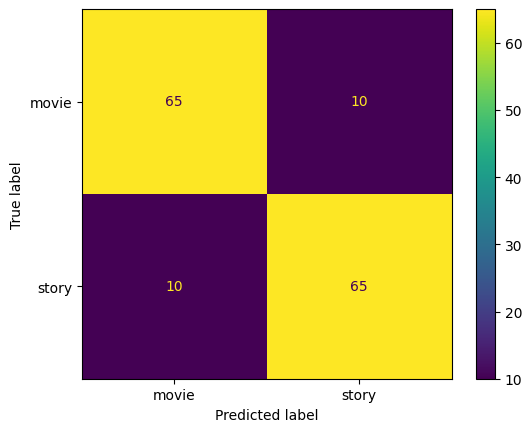

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=["movie", "story"])
disp.plot()

As we can see from the F1-score value, and the confusion matrix, by only leveraging a community detection algorithm we can obtain very good results predicting the subjects stimuli